In [2]:
# !pip install pyorbital h5py

In [5]:
from pyorbital import astronomy
import os
import glob
import h5py
from numpy import pi as pi
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import concurrent.futures as futures
import torch
import matplotlib.pyplot as plt

atl02_dir = '/Users/wndrsn/atl02'
atl09_dir = '/Users/wndrsn/atl09' 

/localscratch/ipykernel_28035/3946941864.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Validate Zenith Calculation Using ATL09 Data

In [4]:
def gps_to_datetime(gps_seconds):
    gps_epoch = datetime(2018, 1, 1)
    gps_time = gps_epoch + timedelta(seconds=gps_seconds)
    return gps_time

def find_atl09_solar_zeniths(dataset):
    if dataset > 90:
        return 'night'
    else:
        return 'day'
    
def read_in_atl09_l1b(file):
    try:
        atl09 = pd.DataFrame()
        with h5py.File(file, 'r') as data:
            atl09['solar_elev'] = pd.DataFrame(np.array(data['profile_1/high_rate/solar_elevation']))            
            atl09['Time0_left'] = pd.DataFrame(np.array(data['profile_1/high_rate/delta_time']))
            atl09['Time0_left'] = atl09['Time0_left'].apply(gps_to_datetime)
            atl09['latitude'] = pd.DataFrame(np.array(data['profile_1/high_rate/latitude']))
            atl09['longitude'] = pd.DataFrame(np.array(data['profile_1/high_rate/longitude']))
        return atl09
    except Exception as e:
        print(e)


In [5]:
datadir1 = atl09_dir

datafiles1 = sorted(glob.glob(os.path.join(datadir1, '**/*.h5'), recursive=True))

with futures.ProcessPoolExecutor() as executor:
    atl09_futures = [executor.submit(read_in_atl09_l1b, file) for file in datafiles1]    
    atl09_results = [future.result() for future in tqdm(atl09_futures)] 
    atl09_results = pd.concat(atl09_results)

100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


# Calculate Zenith Angle 

Average percent error = 1.07%

Max difference = 0.576 degrees

In [6]:
utc_time = atl09_results['Time0_left']
lon = atl09_results['longitude']
lat = atl09_results['latitude']
atl09_results['calculated_angle'] = 90-astronomy.sun_zenith_angle(utc_time, lon, lat)
calc_differences = abs(atl09_results['calculated_angle'])-abs(atl09_results['solar_elev'])
print(f'Average percent error = {(100*(calc_differences)/atl09_results['solar_elev']).mean()}')
print(f'max difference = {abs(calc_differences).max()} degrees')
display(atl09_results[['calculated_angle', 'solar_elev']])

Average percent error = 1.0735291508034364
max difference = 0.5755804555077759 degrees


,calculated_angle,solar_elev
0,66.713678,66.721970
1,66.711136,66.719429
2,66.708584,66.716881
3,66.706038,66.714333
4,66.703493,66.711792
...,...,...
135994,66.721917,66.730232
135995,66.719370,66.727684
135996,66.716822,66.725143
135997,66.714267,66.722588


# Generate ATL02 Datasets

In [7]:
def read_in_atl02(file):
    try:
        atl02 = pd.DataFrame()
        with h5py.File(file, 'r') as data:
            atl02['time']  = pd.DataFrame(np.array(data['/gpsr/navigation/delta_time']))
            atl02['time'] = atl02['time'].apply(gps_to_datetime)
            atl02['lat']  = pd.DataFrame(np.array(data['/gpsr/navigation/latitude']))
            atl02['long']  = pd.DataFrame(np.array(data['/gpsr/navigation/longitude']))
            atl02['zenith'] =  90-astronomy.sun_zenith_angle(atl02['time'], atl02['long'], atl02['lat'])
        return atl02
    except Exception as e:
        print(e)

def getBins(file):
    with h5py.File(file, 'r') as data:
        atm = {k: np.array(data[f'/atlas/pce1/atmosphere_s/{k}']) for k in data['/atlas/pce1/atmosphere_s'].keys()}
        atm_bins = atm['atm_bins']
        n_records = atm_bins.shape[0]
        atm_mean = atm_bins.mean(axis=1, keepdims=True)
        atm_bins_mybackg = atm_bins-atm_mean
        return pd.DataFrame(atm_bins_mybackg)
    
def save_dataframe_to_tensor_file(df, file_path):
    # Convert DataFrame to PyTorch tensor
    tensor_data = torch.tensor(df.values, dtype=torch.float32)
    
    # Save tensor and column names to file
    torch.save({
        'tensor_data': tensor_data,
        'columns': df.columns.tolist()
    }, file_path)

def make_dfs(file, df):
    night_data = []
    i = 0
    is_night = None

    for index, row in df.iterrows():
        if row['zenith'] <= 0:
            # It's night
            if is_night is False or is_night is None:
                # If we were in day or this is the first row, start a new night DataFrame
                night_data.append([])
            night_data[-1].append(row)
            is_night = True
        else:
            # It's day
            if is_night is True:
                # If we were in night, start a new day DataFrame
                night_dataset = pd.DataFrame(night_data[-1])
                i += 1
                save_path = f'{os.path.basename(file).replace(".h5", "")}_{i}.pth'
                # Assuming you have a function to save a DataFrame as a tensor file
                save_dataframe_to_tensor_file(night_dataset, save_path)
            is_night = False

    return night_data

def create_dataset(file):
    df1 = read_in_atl02(file)
    df2 = getBins(file)
    zenith_values = df1['zenith'].tolist()
    repeated_zenith_values = [val for val in zenith_values for _ in range(25)]
    df2['zenith'] = repeated_zenith_values
    make_dfs(file,df2)

In [14]:
datadir2 = atl02_dir
datafiles2 = sorted(glob.glob(os.path.join(datadir2, '**/*.h5'), recursive=True))
# create_dataset(datafiles2[200])
with futures.ProcessPoolExecutor() as executor:
    atl02_futures = [executor.submit(create_dataset, file) for file in datafiles2]    

# Load Tensor File With Dataframe

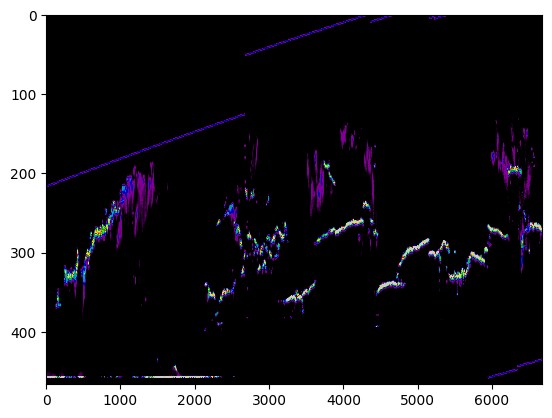

In [8]:
def load_dataframe_from_tensor_file(file_path):
    # Load tensor and column names from file
    data = torch.load(file_path)
    
    # Convert tensor back to DataFrame
    loaded_df = pd.DataFrame(data['tensor_data'].numpy(), columns=data['columns'])
    return loaded_df


df = load_dataframe_from_tensor_file('ATL02_20190101032557_00560210_006_01_1.pth')
atm_bins_mybackg = df[df.columns[:-1]]
plt.imshow(atm_bins_mybackg.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=100)

# Check original dataset against generated 
- Successfully crops out noisy data on the right side

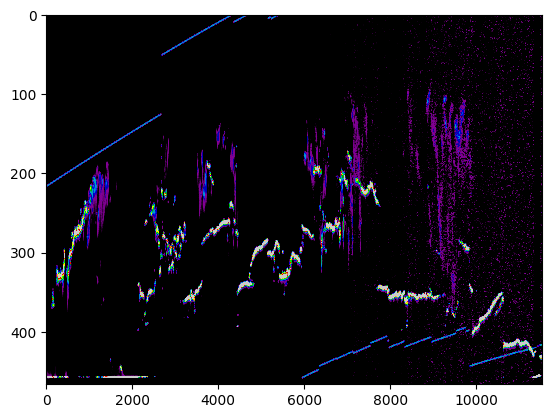

In [9]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import zipfile

def h5toPNGs():
  
  datadir2 = '/Users/wndrsn/atl02'
  file = os.path.join(datadir2,'ATL02_20190101032557_00560210_006_01.h5')
  data = h5py.File(file, 'r')
  atm = {k: np.array(data[f'/atlas/pce1/atmosphere_s/{k}']) for k in data['/atlas/pce1/atmosphere_s'].keys()}
  atm_bins = atm['atm_bins']
  n_records = atm_bins.shape[0]
  data.close()

  
  atm_mean = atm_bins.mean(axis=1, keepdims=True)
  atm_bins_mybackg = atm_bins-atm_mean

  #reduce vmax to 25 to get more noise to show up
  plt.imshow(atm_bins_mybackg.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=50)
      

h5toPNGs()